In [1]:
import cv2
import os

In [2]:
# 打开视频文件
video_path = "/mnt/data/minghao/EPIC-KITCHENS/P06/videos/P02_109.MP4"
video_path = "/data/minghao/dataset/demo/P02_109.MP4"
video_path = "/data/minghao/dataset/demo/P28_12.MP4"
output_dir = "/home/minghao/code/vlm/molmo/demo_output"
cap = cv2.VideoCapture(video_path)

In [3]:
# 检查视频是否打开成功
if not cap.isOpened():
    print("Error: Unable to open video.")
    exit()

In [ ]:
# 获取视频的帧率 (fps)
fps = cap.get(cv2.CAP_PROP_FPS)

# 获取指定时间（例如：5秒）
time_in_seconds = 5

# 根据时间计算出帧数
frame_number = int(time_in_seconds * fps)

# 跳转到指定帧
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# 读取该帧
ret, frame = cap.read()

if ret:
    file_name = os.path.splitext(os.path.basename(video_path))[0]
    output_image_path = os.path.join(output_dir, "{}_at_{}_seconds.jpg".format(file_name, time_in_seconds))
    cv2.imwrite(output_image_path, frame)
    print(f"Frame saved at {output_image_path}")
else:
    print(f"Error: Could not read frame at {time_in_seconds} seconds")

# 释放资源
cap.release()

Frame saved at /home/minghao/code/vlm/molmo/demo_output/P28_12_at_5_seconds.jpg


In [5]:
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig
from PIL import Image
import requests

/home/minghao/miniconda3/envs/molmo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
github_model_dir = '/home/minghao/warehouse/molmo/model/Molmo-7B-D-0924'
molmo_7b = '/data/minghao/molmo/hf/Molmo-7B-D-0924'
molmo_1b = '/data/minghao/molmo/hf/MolmoE-1B-0924'

model_dir = molmo_1b

# video_path = "/mnt/data/minghao/EPIC-KITCHENS/P06/videos/P02_109.MP4"

# load the processor
processor = AutoProcessor.from_pretrained(
    model_dir, # 'allenai/Molmo-7B-D-0924',
    trust_remote_code=True,
    torch_dtype='auto',
    device_map='auto'
)

# load the model
model = AutoModelForCausalLM.from_pretrained(
    model_dir, # 'allenai/Molmo-7B-D-0924',
    trust_remote_code=True,
    torch_dtype='auto',
    device_map='auto'
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPTNeoXTokenizer'. 
The class this function is called from is 'GPT2TokenizerFast'.


In [7]:
# process the image and text
# Open the image from the file path
inputs = processor.process(
    images=[Image.open(output_image_path)],
    text="What object is the hand holding? Only answer the name of the object."
    # text="Describe this image."
)

# move inputs to the correct device and make a batch of size 1
inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

# generate output; maximum 200 new tokens; stop generation when <|endoftext|> is generated
output = model.generate_from_batch(
    inputs,
    GenerationConfig(max_new_tokens=200, stop_strings="<|endoftext|>"),
    tokenizer=processor.tokenizer
)

# only get generated tokens; decode them to text
generated_tokens = output[0,inputs['input_ids'].size(1):]
generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

# print the generated text
print(generated_text)

 Fork


In [8]:
# process the image and text
# Open the image from the file path
inputs = processor.process(
    images=[Image.open(output_image_path)],
    text="Point out where the hand is holding the object."
    # text="Describe this image."
)

# move inputs to the correct device and make a batch of size 1
inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

# generate output; maximum 200 new tokens; stop generation when <|endoftext|> is generated
output = model.generate_from_batch(
    inputs,
    GenerationConfig(max_new_tokens=200, stop_strings="<|endoftext|>"),
    tokenizer=processor.tokenizer
)

# only get generated tokens; decode them to text
generated_tokens = output[0,inputs['input_ids'].size(1):]
generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

# print the generated text
print(generated_text)

 <point x="44.0" y="71.9" alt="hand is holding the object">hand is holding the object</point>


In [9]:
import re

# Use regular expression to find the coordinates in the generated_text
pattern = r'<point x="([\d.]+)" y="([\d.]+)" alt="[^"]+">[^<]+</point>'
match = re.search(pattern, generated_text)

if match:
    x = float(match.group(1))
    y = float(match.group(2))
    print(f"Coordinates extracted: x={x}, y={y}")
else:
    print("No coordinates found in the generated text.")

Coordinates extracted: x=44.0, y=71.9


In [34]:
# Load the image
image_w_point = cv2.imread(output_image_path)

# Convert ratio coordinates to absolute integer values
height, width, _ = image_w_point.shape
x_abs = int(x * width / 100)
y_abs = int(y * height / 100)

# Draw a circle at the specified coordinates
cv2.circle(image_w_point, (x_abs, y_abs), radius=5, color=(0, 0, 255), thickness=-1)

# Define the new output image path
new_output_image_path = os.path.join(output_dir, "{}_with_point.jpg".format(file_name))

# Save the modified image
cv2.imwrite(new_output_image_path, image_w_point)

print(f"Image with point saved at {new_output_image_path}")

Image with point saved at /home/minghao/code/vlm/molmo/demo_output/P28_12_with_point.jpg


# SAM

In [13]:
import torch
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [25]:
from PIL import Image
import numpy as np

# 使用 PIL 加载图像
image = Image.open(output_image_path).convert("RGB")

# # 或者，将图像转换为 NumPy 数组
# image_np = np.array(image)

In [27]:
sam2_model_path = "/data/minghao/sam2/sam2.1-hiera-large/"
sam2_model_path = "facebook/sam2-hiera-large"
predictor = SAM2ImagePredictor.from_pretrained(sam2_model_path)

input_point = np.array([[x_abs, y_abs]])
input_label = np.array([1])

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(image)
    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )


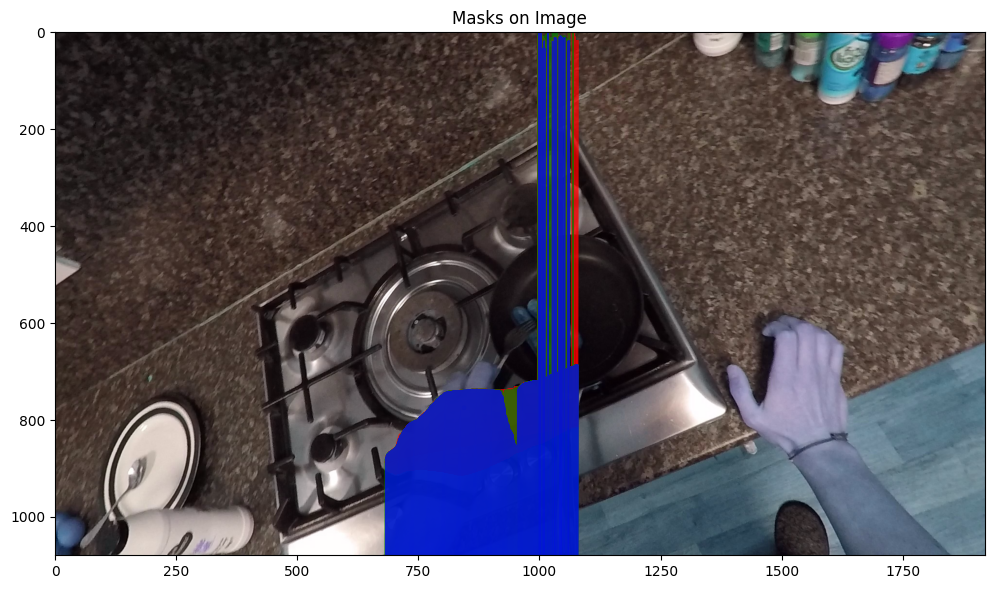

In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define a list of colors for the masks
colors = ['red', 'green', 'blue']

# Create a figure and axis
fig, ax = plt.subplots(1, figsize=(12, 8))

# Display the image
ax.imshow(image_w_point)

# Loop through each mask and add it to the plot
for i, mask in enumerate(masks):
    # Create a colored overlay for the mask
    colored_mask = np.zeros_like(mask, dtype=np.uint8)
    colored_mask[mask > 0] = 255
    
    # Create a patch for the mask
    patch = patches.Polygon(np.argwhere(mask > 0), closed=True, fill=True, color=colors[i % len(colors)], alpha=0.7)
    ax.add_patch(patch)

# Set the title and show the plot
ax.set_title('Masks on Image')
plt.show()